In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
pip install split-folders[full]

Note: you may need to restart the kernel to use updated packages.


In [4]:
import splitfolders

splitfolders.ratio("/kaggle/input/yoga-pose-image-classification-dataset/dataset", output="SubsetYOGA_train_val_test",
                   seed=1337, ratio=(.7, .1, .2), group_prefix=None, move=False)

Copying files: 5994 files [00:34, 172.48 files/s]


In [5]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [6]:
train_path = 'SubsetYOGA_train_val_test/train'
val_path = 'SubsetYOGA_train_val_test/val'
test_path = 'SubsetYOGA_train_val_test/test'
batch_size = 32

In [7]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  shear_range=0.2,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(train_path,
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 4147 images belonging to 107 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1.0/255)  
test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(224,224),
                                           batch_size=32,
                                           shuffle=False)

Found 1294 images belonging to 107 classes.


In [9]:
labels = {value: key for key, value in train_batches.class_indices.items()}

print("Label Mappings for classes present in the training dataset\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training dataset

0 : adho mukha svanasana
1 : adho mukha vriksasana
2 : agnistambhasana
3 : ananda balasana
4 : anantasana
5 : anjaneyasana
6 : ardha bhekasana
7 : ardha chandrasana
8 : ardha matsyendrasana
9 : ardha pincha mayurasana
10 : ardha uttanasana
11 : ashtanga namaskara
12 : astavakrasana
13 : baddha konasana
14 : bakasana
15 : balasana
16 : bhairavasana
17 : bharadvajasana i
18 : bhekasana
19 : bhujangasana
20 : bhujapidasana
21 : bitilasana
22 : camatkarasana
23 : chakravakasana
24 : chaturanga dandasana
25 : dandasana
26 : dhanurasana
27 : durvasasana
28 : dwi pada viparita dandasana
29 : eka pada koundinyanasana i
30 : eka pada koundinyanasana ii
31 : eka pada rajakapotasana
32 : eka pada rajakapotasana ii
33 : ganda bherundasana
34 : garbha pindasana
35 : garudasana
36 : gomukhasana
37 : halasana
38 : hanumanasana
39 : janu sirsasana
40 : kapotasana
41 : krounchasana
42 : kurmasana
43 : lolasana
44 : makara adho mukha svanasana


In [10]:
img_width, img_height = 224, 224
batch_size = 32
epochs = 50
num_classes = 107

In [11]:
from tensorflow.keras.applications import Xception
base_model = Xception(weights='imagenet', include_top=False, 
                         input_shape=(img_width, img_height, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [13]:
from tensorflow.keras.layers import *

In [14]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, BatchNormalization, Reshape
import tensorflow as tf

def soft_attention_block(x, units):
    # Assuming 'x' is the input tensor to the soft attention block
    # 'units' is the number of units in the attention mechanism

    # Perform global average pooling to get channel-wise attention weights
    channel_attention = GlobalAveragePooling2D()(x)
    channel_attention = Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(channel_attention)
    channel_attention = Dense(x.shape[-1], activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))(channel_attention)
    channel_attention = Reshape((1, 1, x.shape[-1]))(channel_attention)

    # Apply channel-wise attention
    x = tf.keras.layers.Multiply()([x, channel_attention])

    # Calculate the spatial dimensions of the input tensor
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]

    # Perform global max pooling to get spatial attention weights
    spatial_attention = tf.keras.layers.GlobalMaxPooling2D()(x)
    spatial_attention = Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(spatial_attention)
    spatial_attention = Dense(height * width, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))(spatial_attention)
    spatial_attention = Reshape((height, width, 1))(spatial_attention)

    # Apply spatial attention
    x = tf.keras.layers.Multiply()([x, spatial_attention])

    # Combine the attention-weighted features using a skip connection
    x = tf.keras.layers.Add()([x, channel_attention])

    return x



In [15]:
x = base_model.output

x = soft_attention_block(x, 1280)

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = soft_attention_block(x, 1024)

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = GlobalAveragePooling2D()(x)

x = tf.keras.layers.Reshape((1, 1, 512))(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(x)

x = GlobalAveragePooling2D()(x)

preds = tf.keras.layers.Reshape((num_classes,))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=preds)


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.applications import ResNet152V2, DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, InputLayer, BatchNormalization, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
#from keras_self_attention import SeqSelfAttention

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

In [17]:
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('Xception.h5.keras',
                             monitor='val_accuracy', save_best_only=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)

In [18]:
history=model.fit(train_batches, epochs=200, validation_data=test_batches, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/130 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - accuracy: 0.0089 - loss: 119.1262 - mse: 0.0093

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.0090 - loss: 119.0248 - mse: 0.0093
Epoch 1: val_accuracy improved from -inf to 0.00618, saving model to Xception.h5.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 178s 858ms/step - accuracy: 0.0091 - loss: 119.0124 - mse: 0.0093 - val_accuracy: 0.0062 - val_loss: 113.8559 - val_mse: 0.0093 - learning_rate: 1.0000e-05
Epoch 2/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.0144 - loss: 112.5600 - mse: 0.0093
Epoch 2: val_accuracy improved from 0.00618 to 0.01468, saving model to Xception.h5.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 76s 557ms/step - accuracy: 0.0144 - loss: 112.5481 - mse: 0.0093 - val_accuracy: 0.0147 - val_loss: 107.7813 - val_mse: 0.0093 - learning_rate: 1.0000e-05
Epoch 3/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.0255 - loss: 106.4230 - mse: 0.0093
Epoch 3: val_accuracy improved from 0.01468 to 0.01777, saving model to Xception.h5.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 77s 561ms/step - accuracy: 0.025

In [19]:
test_result = model.evaluate(test_batches)
#                             steps=test_generator.samples // batch_size)
test_loss = test_result[0]
test_accuracy = test_result[1]
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.5609 - loss: 14.6341 - mse: 0.0054
Test Loss: 14.69921875
Test Accuracy: 0.5595054030418396


In [20]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

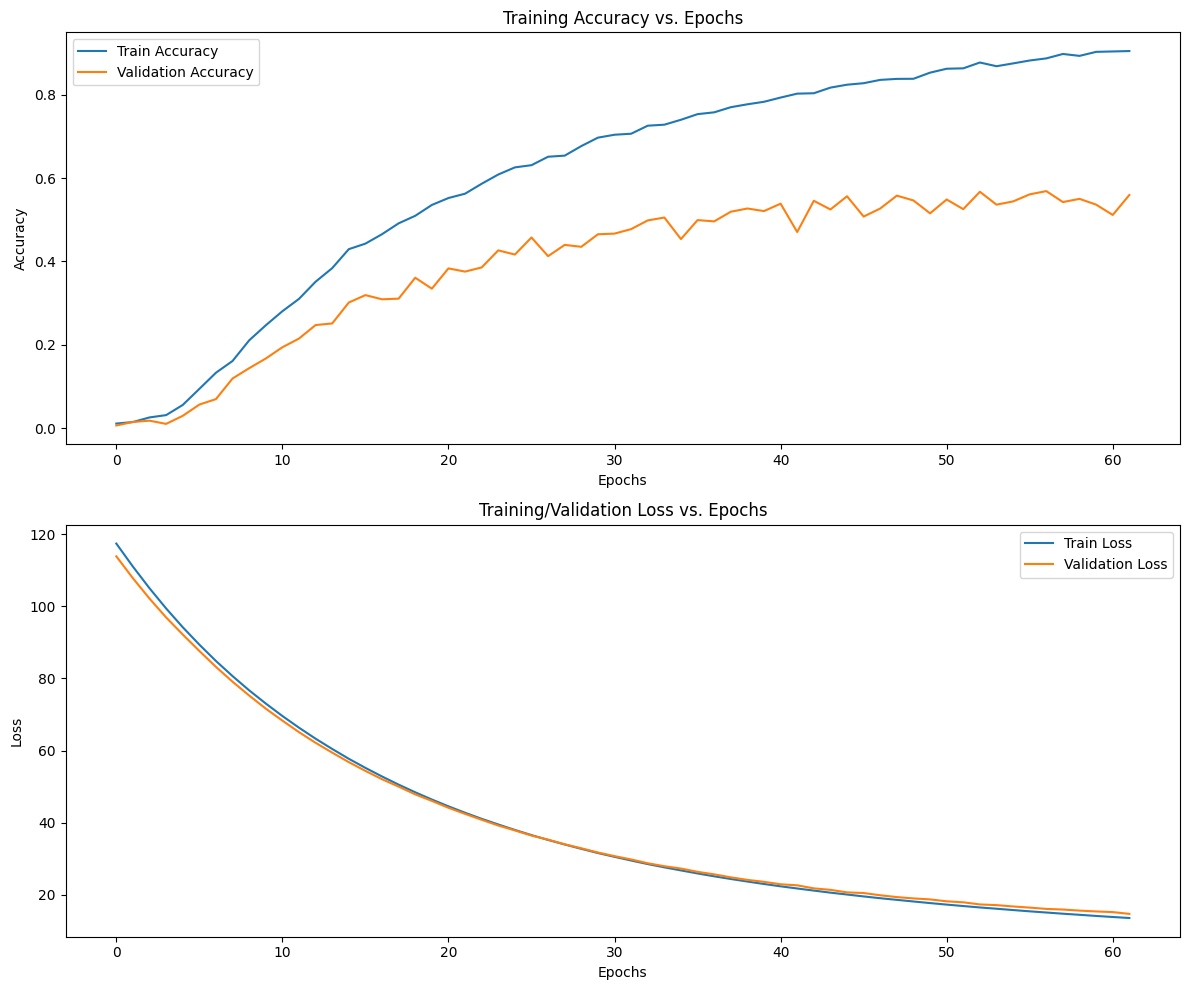

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy,label='Train Accuracy')
ax[0].plot(val_accuracy,label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss,label='Train Loss')
ax[1].plot(val_loss,label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()


In [22]:
train_class_names = sorted(list(train_batches.class_indices.keys()))

test_class_names = sorted(list(test_batches.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step


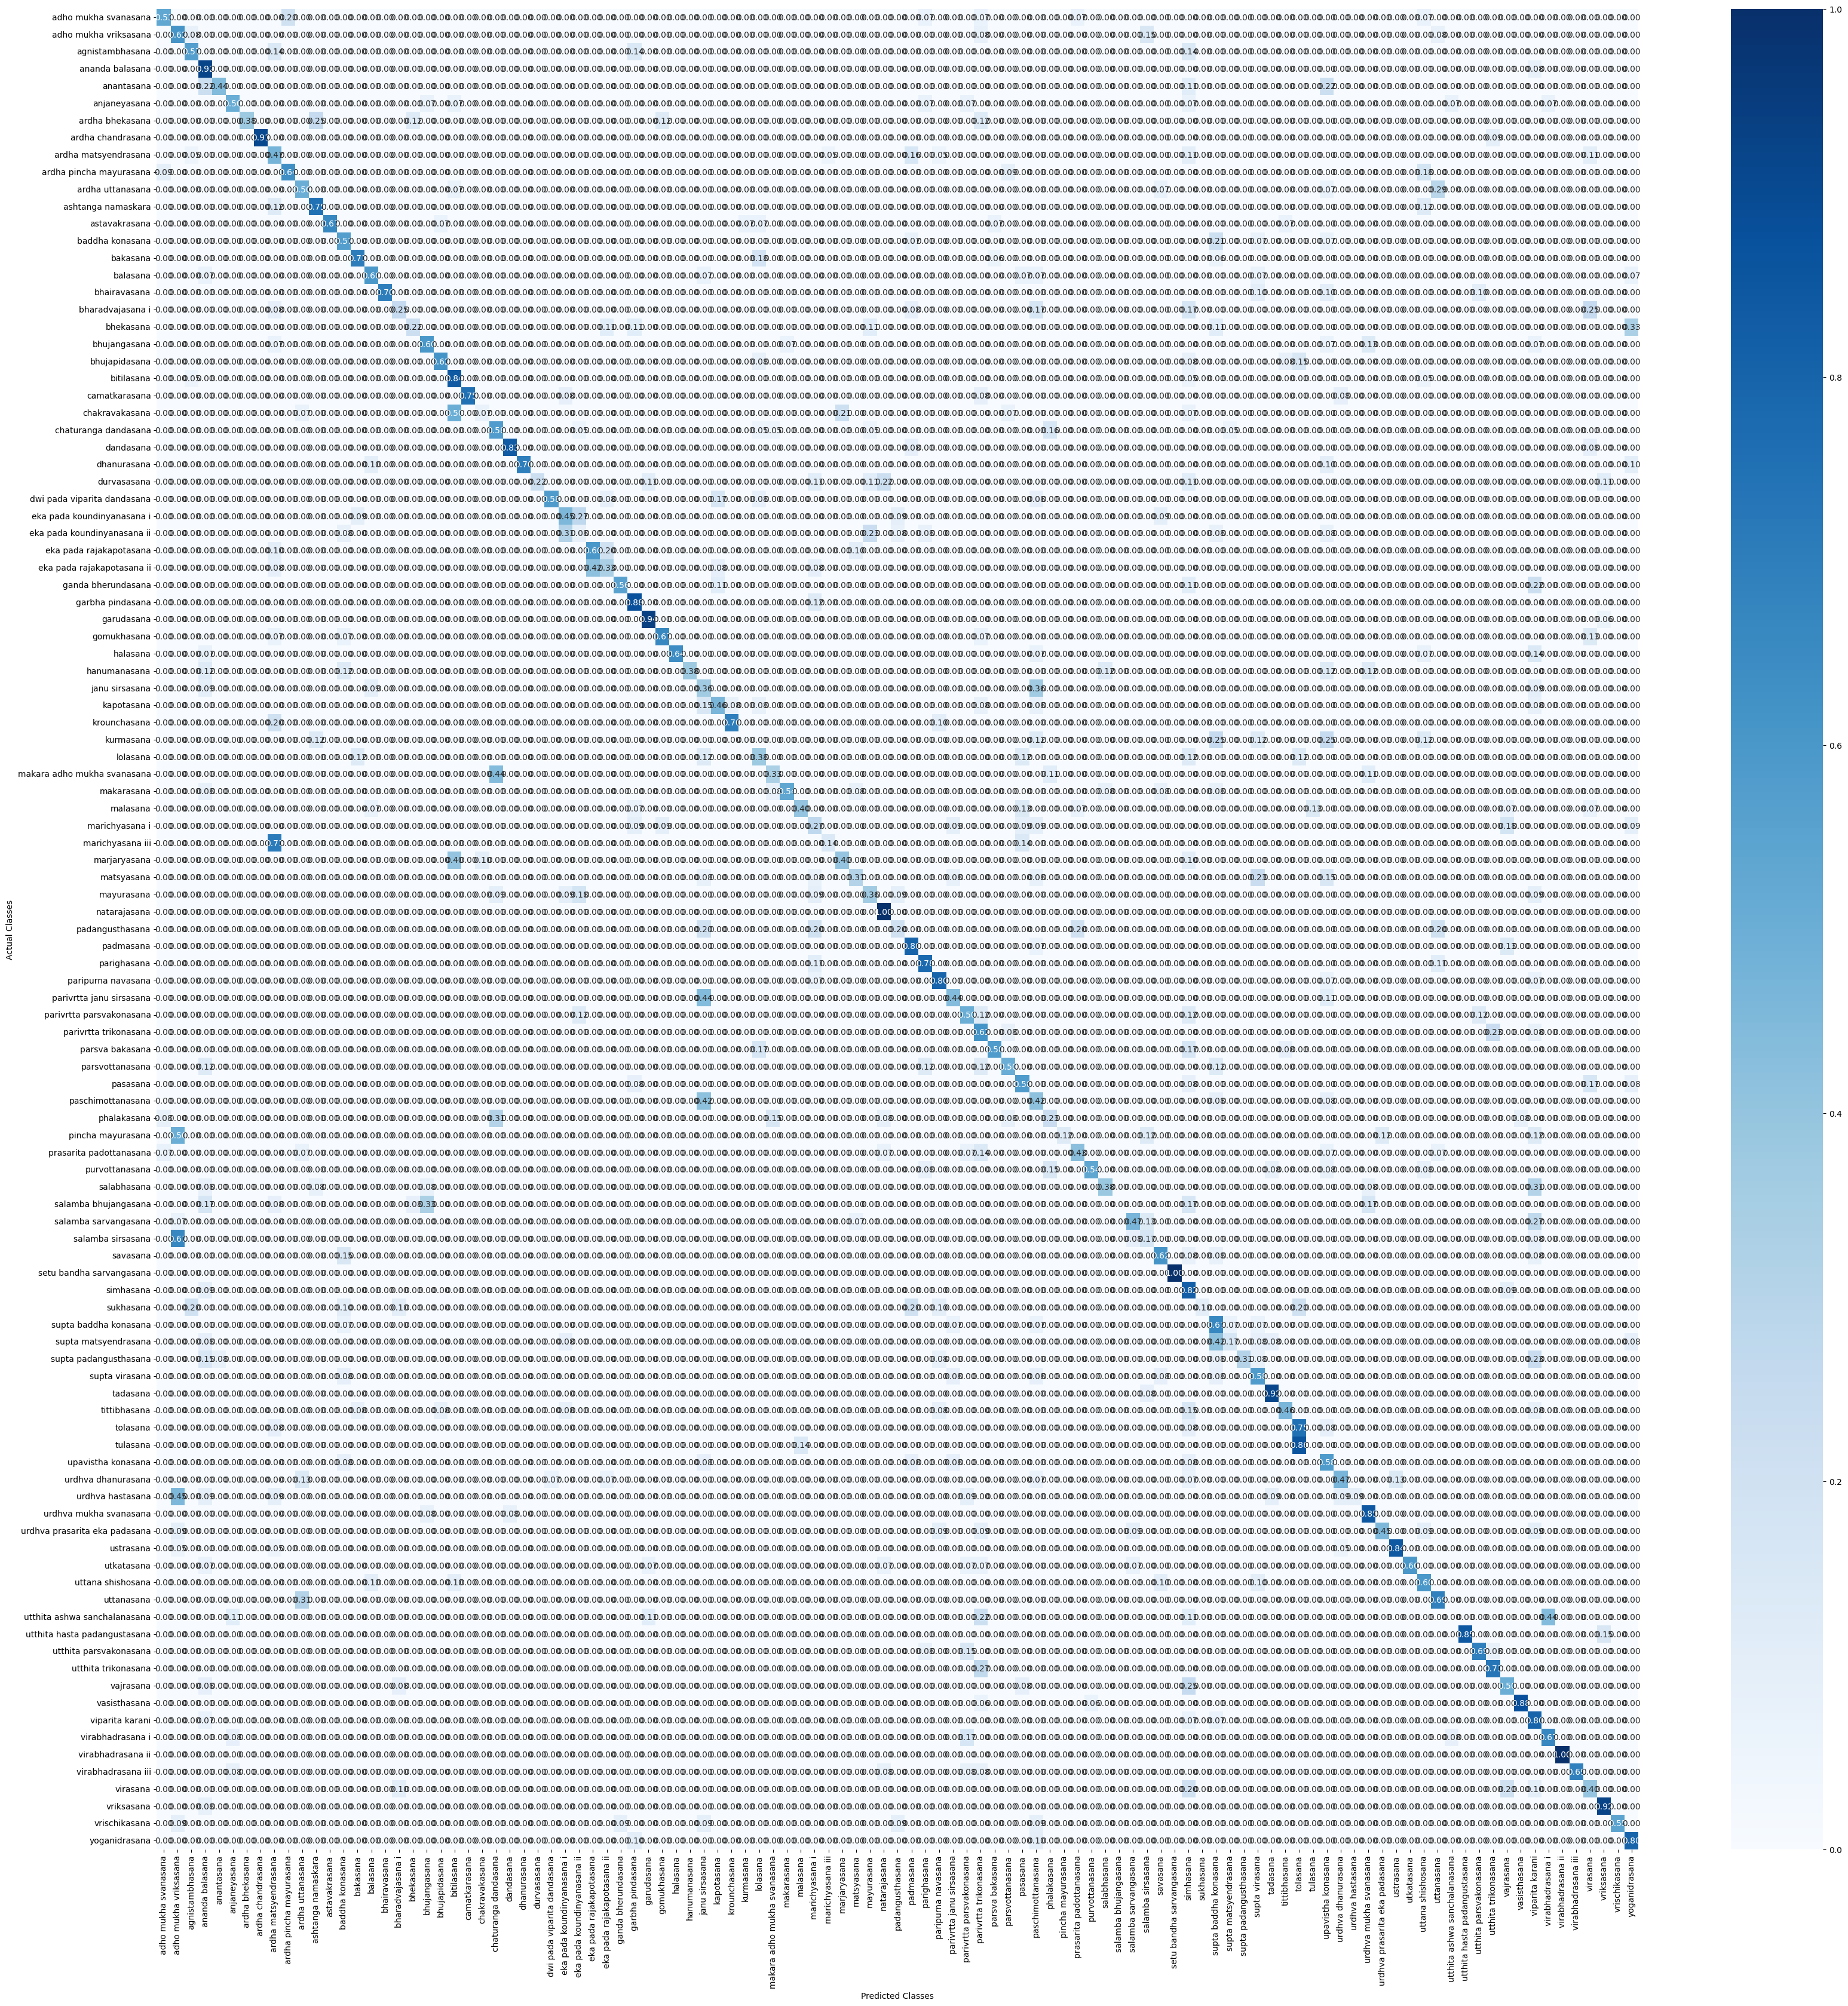

Confusion Matrix:
[[ 8  0  0 ...  0  0  0]
 [ 0  8  1 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 0  1  0 ...  0  6  0]
 [ 0  0  0 ...  0  0  8]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_batches.classes

# Generate predictions for the test data
predictions = model.predict(test_batches)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')

output_file = 'ConfusionMatrix_Xception_SplittedDataset_SoftAtt.png'  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)

In [24]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.28      0.62      0.38        13
           2       0.44      0.57      0.50         7
           3       0.38      0.92      0.53        13
           4       0.80      0.44      0.57         9
           5       0.70      0.50      0.58        14
           6       1.00      0.38      0.55         8
           7       1.00      0.91      0.95        11
           8       0.33      0.47      0.39        19
           9       0.70      0.64      0.67        11
          10       0.47      0.50      0.48        14
          11       0.60      0.75      0.67         8
          12       1.00      0.67      0.80        15
          13       0.47      0.57      0.52        14
          14       0.80      0.71      0.75        17
          15       0.69      0.60      0.64        15
          16       1.00      0.70      0.82        10
    

In [25]:
from keras.models import load_model
model.save('xception.h5.keras')


In [26]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, 
                         input_shape=(img_width, img_height, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
x = base_model.output

x = soft_attention_block(x, 1280)

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = soft_attention_block(x, 1024)

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = GlobalAveragePooling2D()(x)

x = tf.keras.layers.Reshape((1, 1, 512))(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(x)

x = GlobalAveragePooling2D()(x)

preds = tf.keras.layers.Reshape((num_classes,))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=preds)


In [28]:
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('mobilenetv2.h5.keras',
                             monitor='val_accuracy', save_best_only=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)

In [ ]:
history=model.fit(train_batches, epochs=200, validation_data=test_batches, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])

Epoch 1/200
 68/130 ━━━━━━━━━━━━━━━━━━━━ 30s 491ms/step - accuracy: 0.0079 - loss: 109.0535 - mse: 0.0093

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.0090 - loss: 108.5693 - mse: 0.0093
Epoch 1: val_accuracy improved from -inf to 0.01159, saving model to mobilenetv2.h5.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 171s 827ms/step - accuracy: 0.0090 - loss: 108.5617 - mse: 0.0093 - val_accuracy: 0.0116 - val_loss: 105.2696 - val_mse: 0.0093 - learning_rate: 1.0000e-05
Epoch 2/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.0170 - loss: 104.5076 - mse: 0.0093
Epoch 2: val_accuracy improved from 0.01159 to 0.01546, saving model to mobilenetv2.h5.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 73s 534ms/step - accuracy: 0.0170 - loss: 104.5002 - mse: 0.0093 - val_accuracy: 0.0155 - val_loss: 101.4866 - val_mse: 0.0093 - learning_rate: 1.0000e-05
Epoch 3/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.0292 - loss: 100.6172 - mse: 0.0093
Epoch 3: val_accuracy improved from 0.01546 to 0.02473, saving model to mobilenetv2.h5.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 71s 520ms/step - accura

In [33]:
test_result = model.evaluate(test_batches)
#                             steps=test_generator.samples // batch_size)
test_loss = test_result[0]
test_accuracy = test_result[1]
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.5324 - loss: 65.2082 - mse: 0.0129
Test Loss: 65.14800262451172
Test Accuracy: 0.5675675868988037


In [34]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

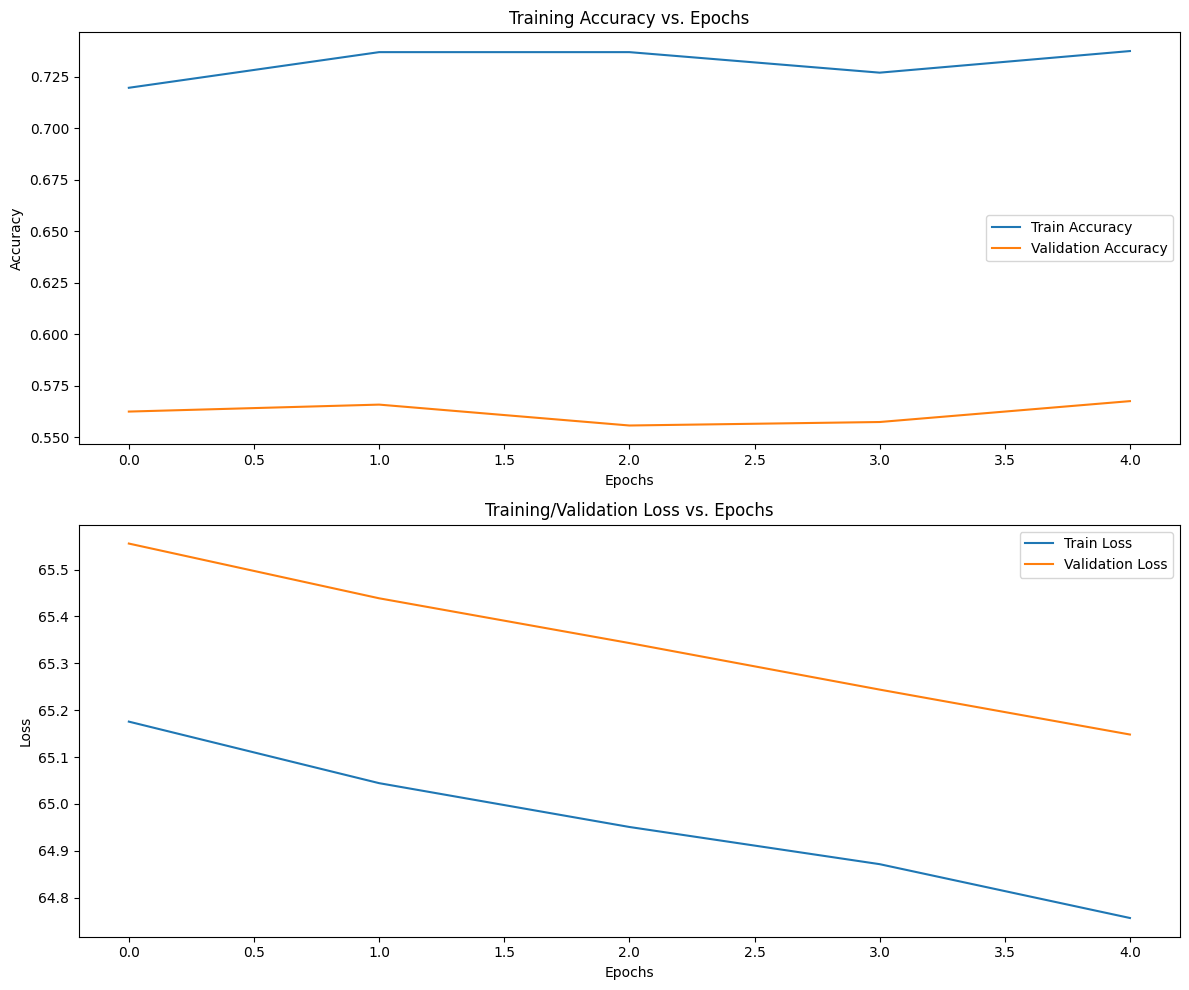

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy,label='Train Accuracy')
ax[0].plot(val_accuracy,label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss,label='Train Loss')
ax[1].plot(val_loss,label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()


In [36]:
train_class_names = sorted(list(train_batches.class_indices.keys()))

test_class_names = sorted(list(test_batches.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step


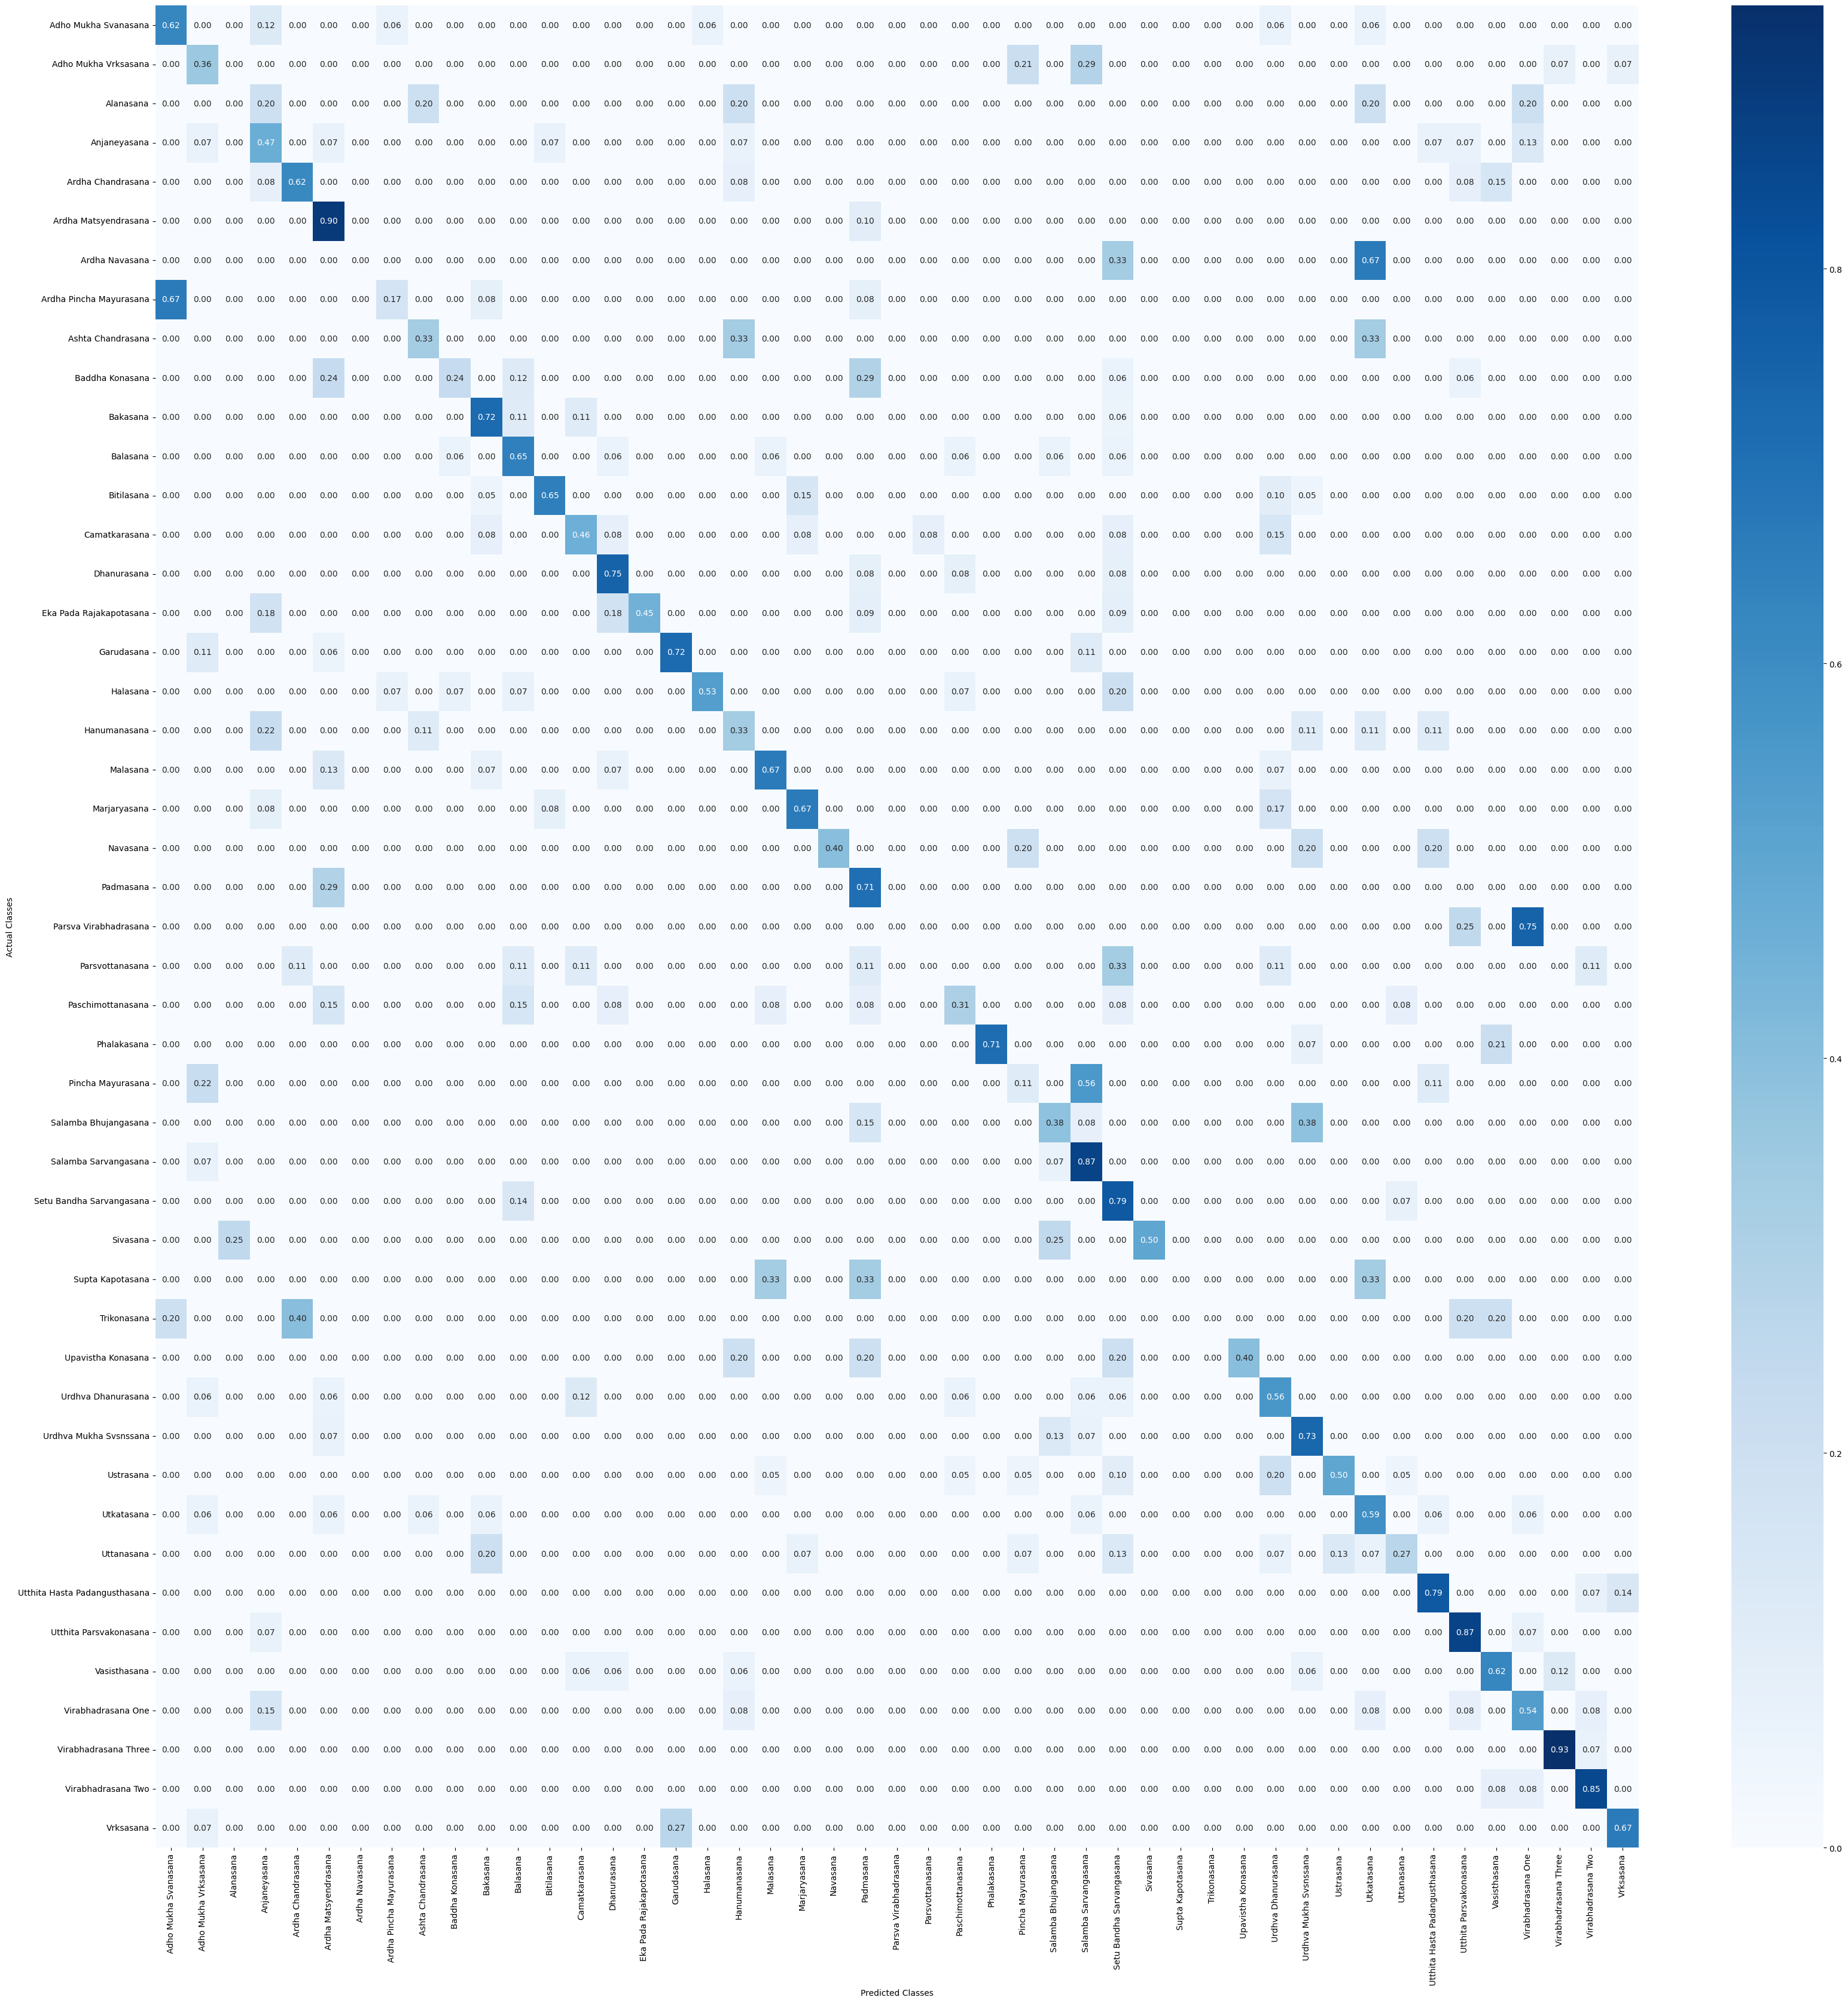

Confusion Matrix:
[[10  0  0 ...  0  0  0]
 [ 0  5  0 ...  1  0  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  1  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  1  0 ...  0  0 10]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_batches.classes

# Generate predictions for the test data
predictions = model.predict(test_batches)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')

output_file = 'ConfusionMatrix_MobileNetV2_SplittedDataset_SoftAtt.png'  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)

In [38]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        16
           1       0.36      0.36      0.36        14
           2       0.00      0.00      0.00         5
           3       0.37      0.47      0.41        15
           4       0.73      0.62      0.67        13
           5       0.50      0.90      0.64        20
           6       0.00      0.00      0.00         3
           7       0.50      0.17      0.25        12
           8       0.25      0.33      0.29         3
           9       0.67      0.24      0.35        17
          10       0.62      0.72      0.67        18
          11       0.52      0.65      0.58        17
          12       0.87      0.65      0.74        20
          13       0.50      0.46      0.48        13
          14       0.56      0.75      0.64        12
          15       1.00      0.45      0.62        11
          16       0.76      0.72      0.74        18
    

In [39]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, 
                         input_shape=(img_width, img_height, 3))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [40]:
x = base_model.output

x = soft_attention_block(x, 1280)

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = soft_attention_block(x, 1024)

x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = GlobalAveragePooling2D()(x)

x = tf.keras.layers.Reshape((1, 1, 512))(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = BatchNormalization()(x)

x = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(x)

x = GlobalAveragePooling2D()(x)

preds = tf.keras.layers.Reshape((num_classes,))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=preds)


In [41]:
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('InceptionV3.h5.keras',
                             monitor='val_accuracy', save_best_only=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)

In [42]:
history=model.fit(train_batches, epochs=200, validation_data=test_batches, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])

Epoch 1/200
10/60 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - accuracy: 0.0078 - loss: 119.0049 - mse: 0.0215

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0170 - loss: 118.5325 - mse: 0.0215
Epoch 1: val_accuracy improved from -inf to 0.02196, saving model to InceptionV3.h5.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.0171 - loss: 118.5223 - mse: 0.0215 - val_accuracy: 0.0220 - val_loss: 116.1675 - val_mse: 0.0208 - learning_rate: 1.0000e-05
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.0335 - loss: 116.0000 - mse: 0.0214
Epoch 2: val_accuracy improved from 0.02196 to 0.03716, saving model to InceptionV3.h5.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 488ms/step - accuracy: 0.0335 - loss: 115.9892 - mse: 0.0214 - val_accuracy: 0.0372 - val_loss: 113.7429 - val_mse: 0.0208 - learning_rate: 1.0000e-05
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.0374 - loss: 113.4052 - mse: 0.0213
Epoch 3: val_accuracy did not improve from 0.03716
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 445ms/step - accuracy: 0.0375 - loss: 113.3946 - mse: 0.0212 - val_accuracy: 0.

In [43]:
test_result = model.evaluate(test_batches)
#                             steps=test_generator.samples // batch_size)
test_loss = test_result[0]
test_accuracy = test_result[1]
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.3512 - loss: 54.4979 - mse: 0.0162
Test Loss: 54.40735626220703
Test Accuracy: 0.40202704071998596


In [44]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

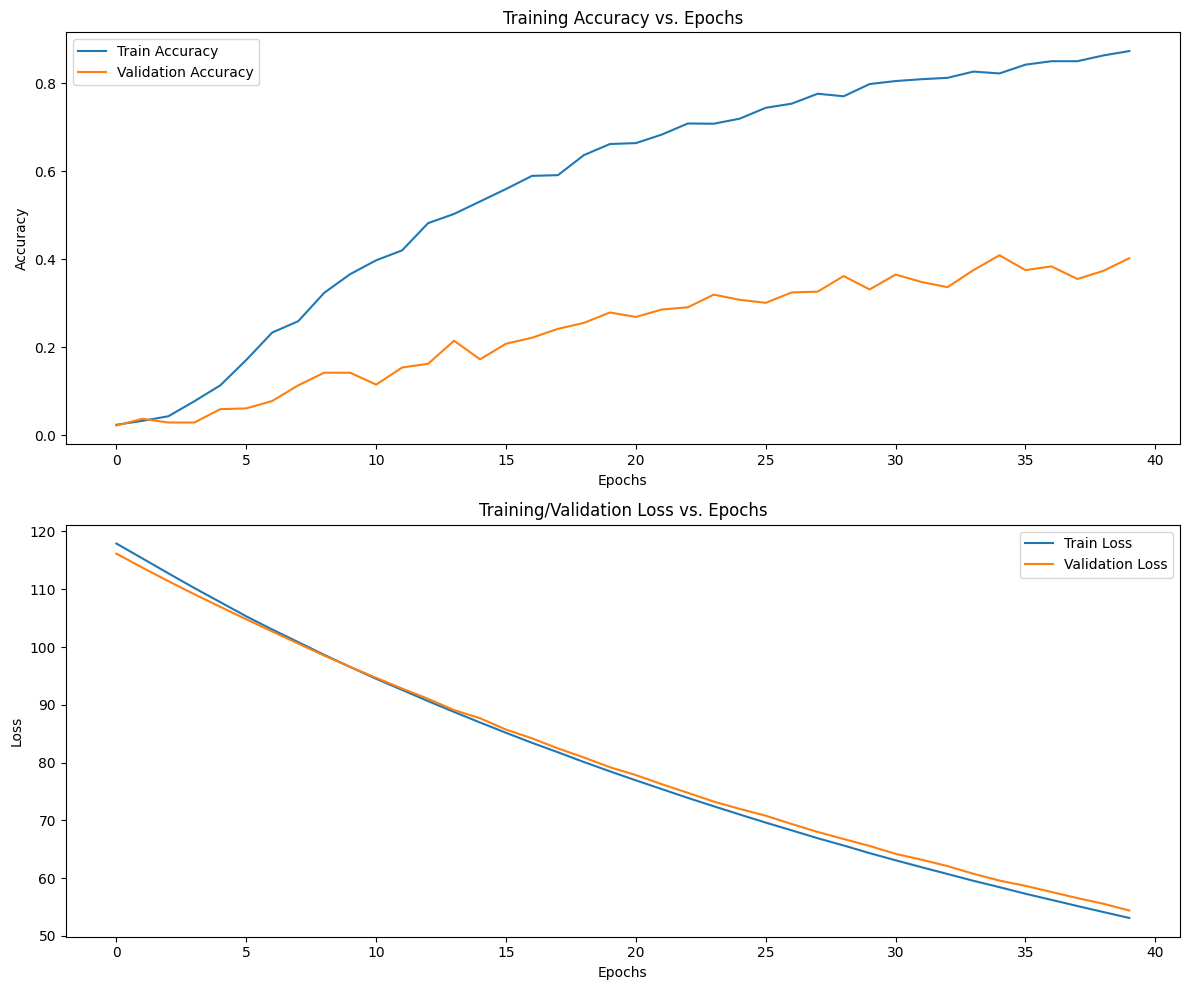

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy,label='Train Accuracy')
ax[0].plot(val_accuracy,label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss,label='Train Loss')
ax[1].plot(val_loss,label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()


In [46]:
train_class_names = sorted(list(train_batches.class_indices.keys()))

test_class_names = sorted(list(test_batches.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


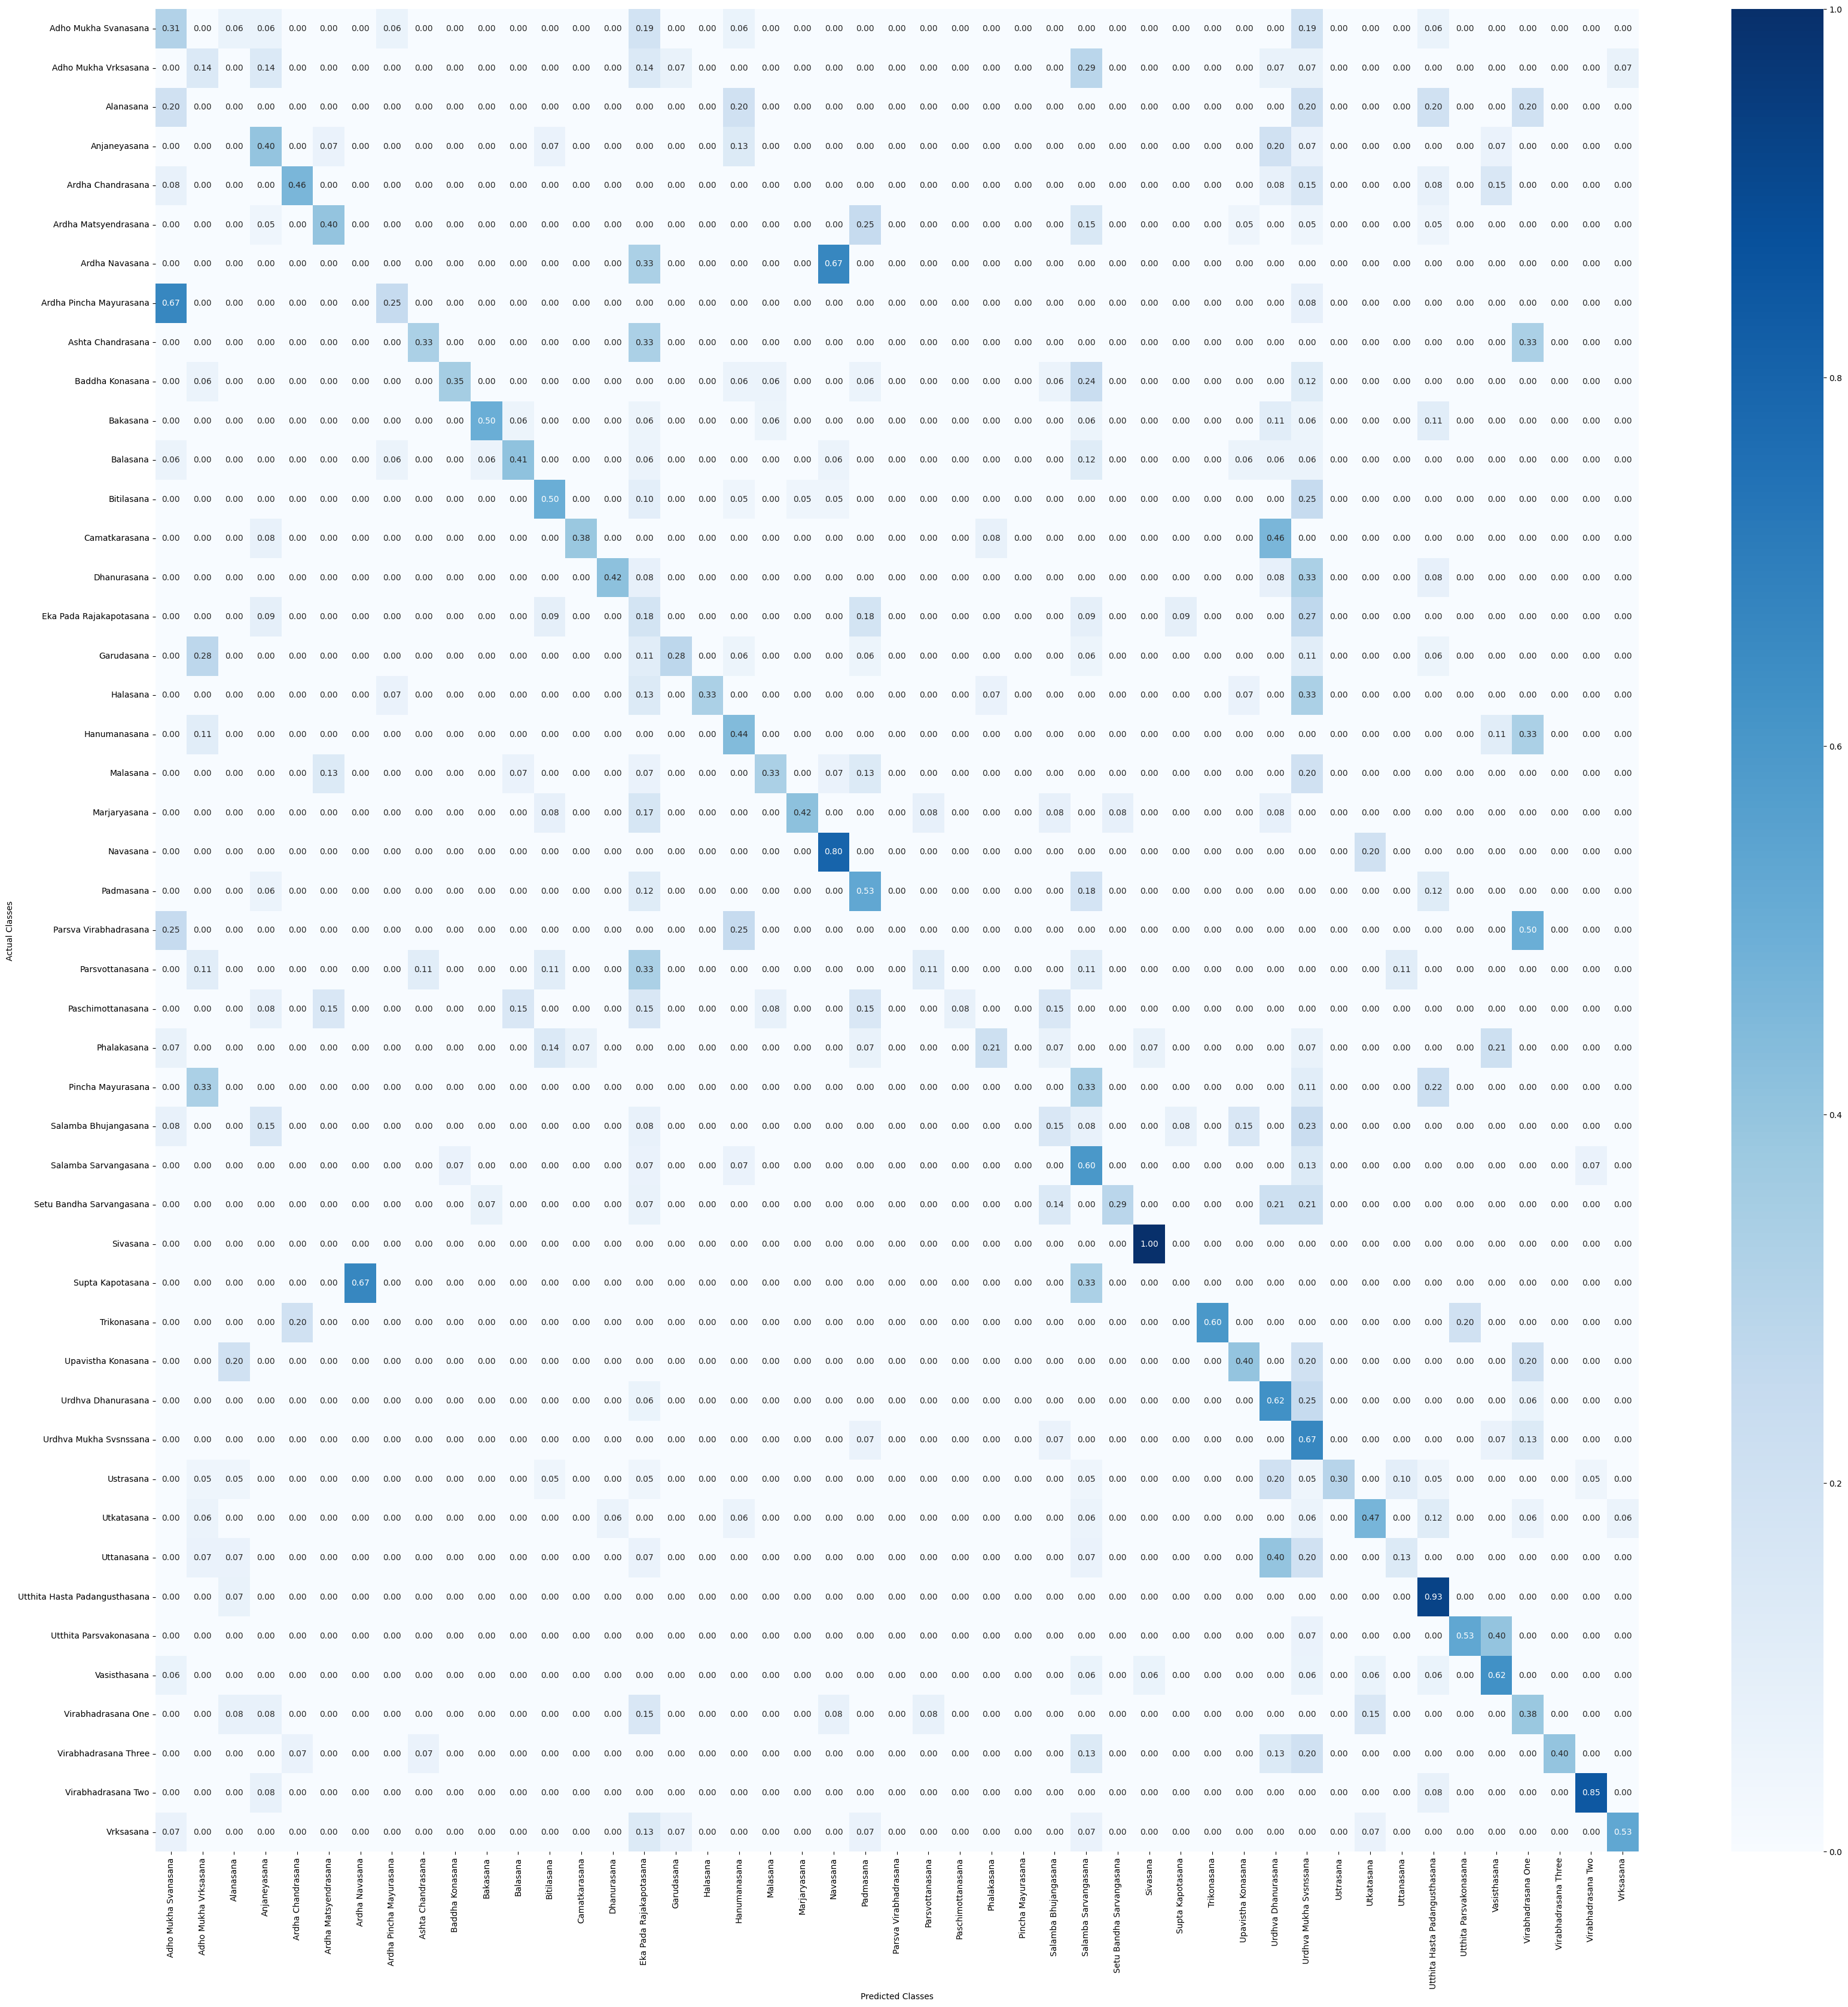

Confusion Matrix:
[[ 5  0  1 ...  0  0  0]
 [ 0  2  0 ...  0  0  1]
 [ 1  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0 11  0]
 [ 1  0  0 ...  0  0  8]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_batches.classes

# Generate predictions for the test data
predictions = model.predict(test_batches)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')

output_file = 'ConfusionMatrix_InceptionV3_SpilitedDataset_SoftAtt.png'  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)

In [49]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.31      0.27        16
           1       0.12      0.14      0.13        14
           2       0.00      0.00      0.00         5
           3       0.33      0.40      0.36        15
           4       0.75      0.46      0.57        13
           5       0.62      0.40      0.48        20
           6       0.00      0.00      0.00         3
           7       0.50      0.25      0.33        12
           8       0.33      0.33      0.33         3
           9       0.86      0.35      0.50        17
          10       0.82      0.50      0.62        18
          11       0.64      0.41      0.50        17
          12       0.59      0.50      0.54        20
          13       0.83      0.38      0.53        13
          14       0.83      0.42      0.56        12
          15       0.05      0.18      0.08        11
          16       0.71      0.28      0.40        18
    

In [50]:
from keras.models import load_model
model.save('InceptionV3.h5.keras')

In [51]:
from tensorflow.keras.models import load_model
model1 = load_model('/kaggle/working/Xception.h5.keras')


In [52]:
model2 = tf.keras.models.load_model('/kaggle/working/mobilenetv2.h5.keras')

In [53]:
model3 = tf.keras.models.load_model('/kaggle/working/InceptionV3.h5.keras')

In [54]:
num_samples = len(test_batches)
num_classes = 47

In [55]:
print(num_samples)

19


In [56]:
predictions = np.zeros((len(test_batches.classes), num_classes))

model_predictions1 = model1.predict(test_batches)
predictions += model_predictions1
model_predictions2 = model2.predict(test_batches)
predictions += model_predictions2
model_predictions3 = model3.predict(test_batches)
predictions += model_predictions3

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 379ms/step


In [57]:
model_predictions1.shape

(592, 47)

In [58]:
# Apply majority voting
ensemble_predictions = np.argmax(predictions, axis=1)

In [59]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
y_true = test_batches.classes
accuracy = accuracy_score(y_true, ensemble_predictions)
print("Ensemble Accuracy:", accuracy)

Ensemble Accuracy: 0.706081081081081


In [60]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, ensemble_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

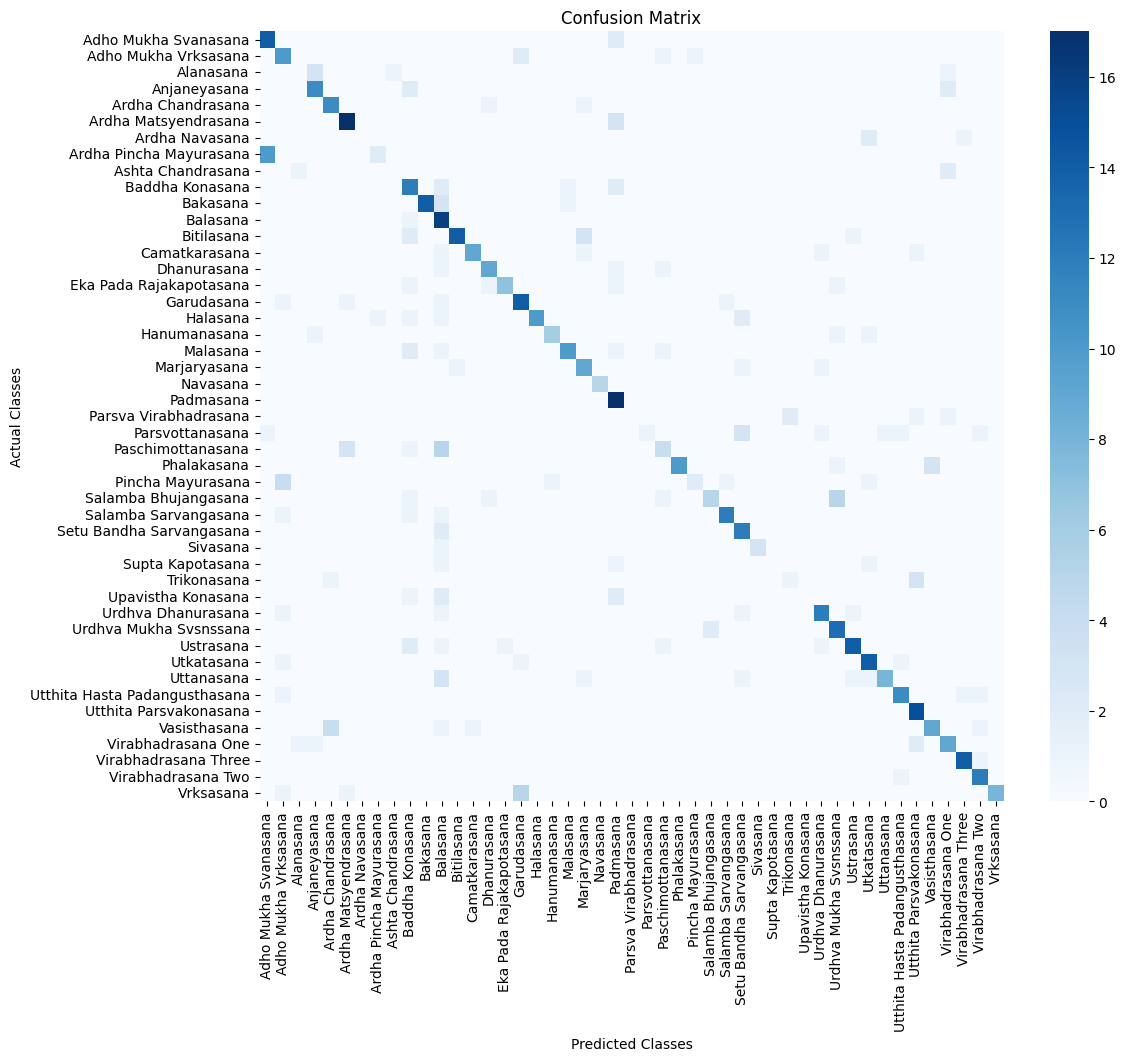

In [88]:
labels = {value: key for key, value in train_batches.class_indices.items()}

label_names = [labels[i] for i in range(len(labels))]  
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt=".2f", cmap="Blues",
            xticklabels=labels.values(),
            yticklabels=labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.savefig("confusion_matrix_ensemble.png", dpi=300, bbox_inches="tight")
plt.show()

In [62]:
from sklearn.metrics import classification_report

classification_report_mv = classification_report(y_true, ensemble_predictions)

print(classification_report_mv)

              precision    recall  f1-score   support

           0       0.58      0.88      0.70        16
           1       0.50      0.64      0.56        14
           2       0.00      0.00      0.00         5
           3       0.59      0.67      0.62        15
           4       0.82      0.69      0.75        13
           5       0.80      0.80      0.80        20
           6       0.00      0.00      0.00         3
           7       0.67      0.17      0.27        12
           8       0.00      0.00      0.00         3
           9       0.59      0.76      0.67        17
          10       0.93      0.78      0.85        18
          11       0.39      0.94      0.55        17
          12       0.88      0.75      0.81        20
          13       0.89      0.62      0.73        13
          14       0.67      0.83      0.74        12
          15       0.67      0.55      0.60        11
          16       0.70      0.78      0.74        18
          17       0.91    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
len(y_true)

592

In [63]:
# Apply product rule ensemble

ensemble_predictions_product_rule = np.multiply(model_predictions1, model_predictions2, model_predictions3)

In [64]:
ensemble_predictions_pr = np.argmax(ensemble_predictions_product_rule, axis=1)

In [65]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
y_true = test_batches.classes
accuracy = accuracy_score(y_true, ensemble_predictions_pr)
print("Ensemble Accuracy:", accuracy)

Ensemble Accuracy: 0.6858108108108109


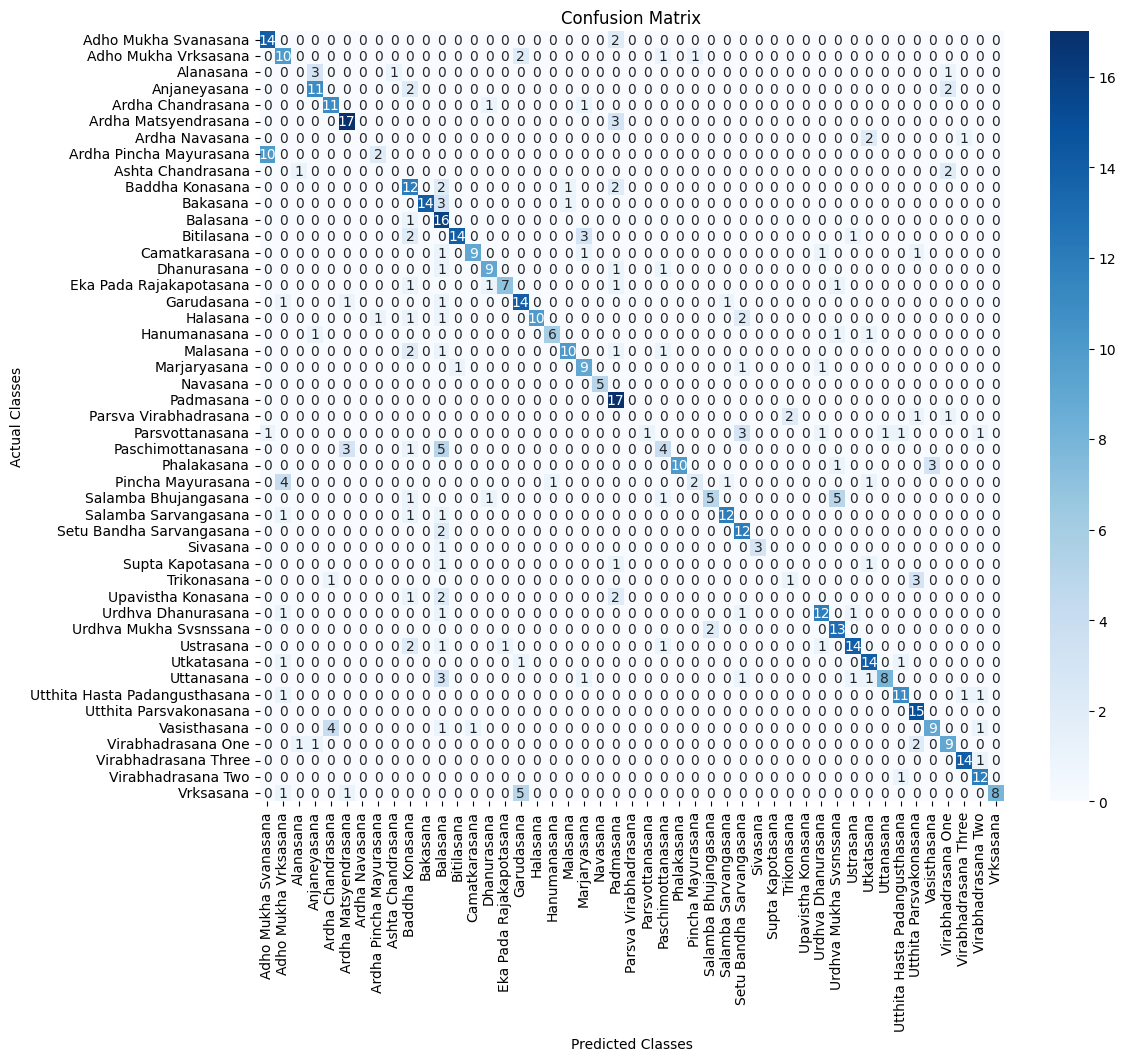

In [87]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, ensemble_predictions_pr)

# Ensure labels is a list
plt.figure(figsize=(12, 10))  # Increase figure size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,  # Use the list directly
            yticklabels=labels)  # Use the list directly
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")

# Save the confusion matrix as an image
plt.savefig("confusion_matrix_pr.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


In [71]:
from sklearn.metrics import classification_report

classification_report_pr = classification_report(y_true, ensemble_predictions_pr)

print(classification_report_pr)

              precision    recall  f1-score   support

           0       0.56      0.88      0.68        16
           1       0.50      0.71      0.59        14
           2       0.00      0.00      0.00         5
           3       0.69      0.73      0.71        15
           4       0.69      0.85      0.76        13
           5       0.77      0.85      0.81        20
           6       0.00      0.00      0.00         3
           7       0.67      0.17      0.27        12
           8       0.00      0.00      0.00         3
           9       0.44      0.71      0.55        17
          10       1.00      0.78      0.88        18
          11       0.36      0.94      0.52        17
          12       0.93      0.70      0.80        20
          13       0.90      0.69      0.78        13
          14       0.75      0.75      0.75        12
          15       0.88      0.64      0.74        11
          16       0.64      0.78      0.70        18
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
# Combine the predictions of the ensemble
ensemble_predictions_sum = []
ensemble_predictions_sum.append(model_predictions1)
ensemble_predictions_sum.append(model_predictions2)
ensemble_predictions_sum.append(model_predictions3)
ensemble_predictions_sum = np.array(ensemble_predictions_sum)
final_predictions_sum = np.mean(ensemble_predictions_sum, axis=0)

In [73]:
final_predict_label = np.argmax(final_predictions_sum, axis=1).astype(int)

In [74]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
y_true = test_batches.classes
accuracy = accuracy_score(y_true, final_predict_label)
print("Ensemble Accuracy:", accuracy)

Ensemble Accuracy: 0.6722972972972973


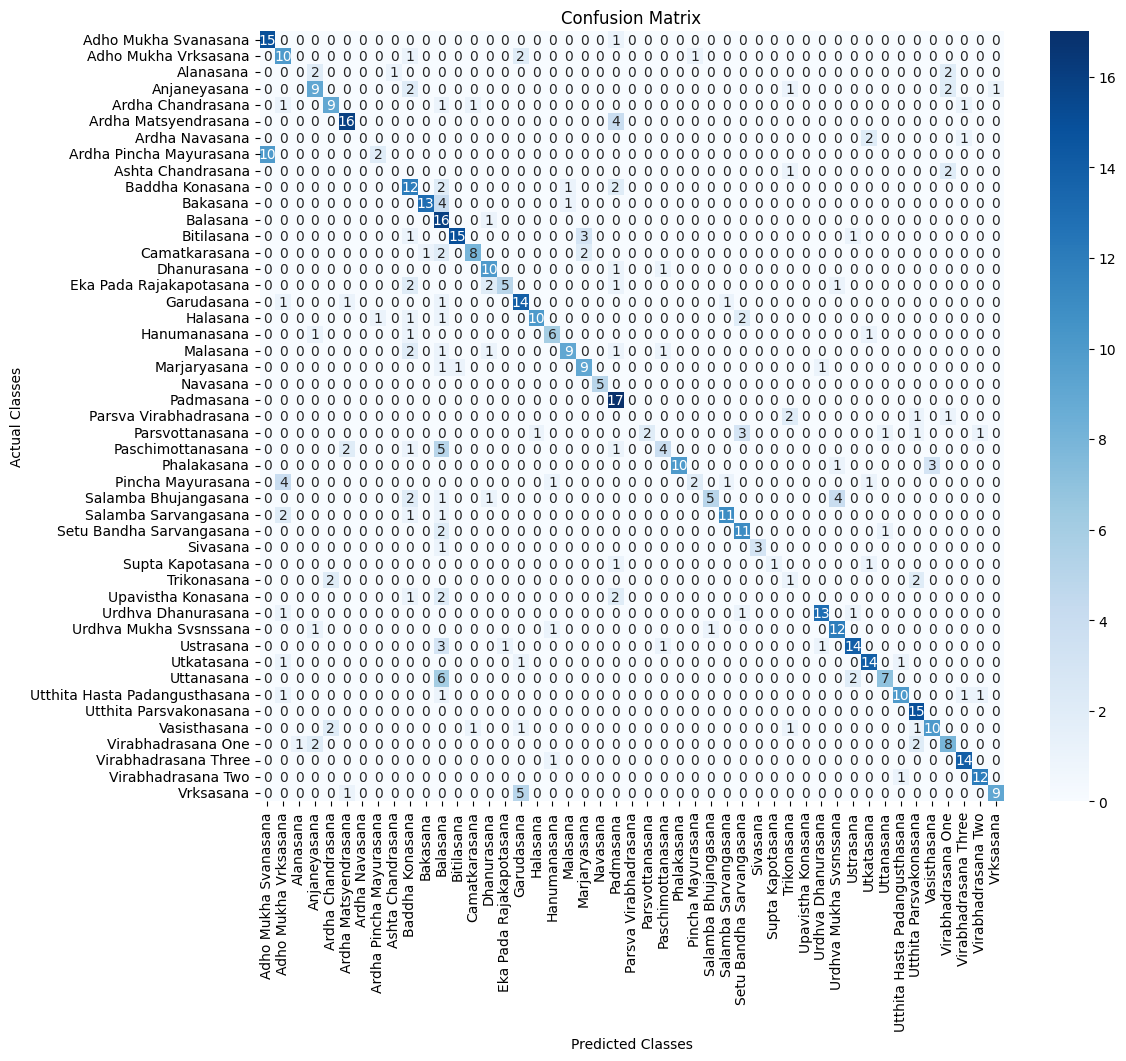

In [86]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, final_predict_label)

# Ensure labels is a list of class names
plt.figure(figsize=(12, 10))  # Increased figure size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,  # Use the list directly
            yticklabels=labels)  # Use the list directly
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")

# Save the confusion matrix as an image
plt.savefig("confusion_matrix1.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


In [76]:
from sklearn.metrics import classification_report

classification_report_sum = classification_report(y_true, final_predict_label)

print(classification_report_sum)

              precision    recall  f1-score   support

           0       0.60      0.94      0.73        16
           1       0.48      0.71      0.57        14
           2       0.00      0.00      0.00         5
           3       0.60      0.60      0.60        15
           4       0.69      0.69      0.69        13
           5       0.80      0.80      0.80        20
           6       0.00      0.00      0.00         3
           7       0.67      0.17      0.27        12
           8       0.00      0.00      0.00         3
           9       0.44      0.71      0.55        17
          10       0.93      0.72      0.81        18
          11       0.31      0.94      0.47        17
          12       0.94      0.75      0.83        20
          13       0.80      0.62      0.70        13
          14       0.67      0.83      0.74        12
          15       0.83      0.45      0.59        11
          16       0.61      0.78      0.68        18
          17       0.91    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
#weighted
from sklearn.metrics import accuracy_score

m1_label = np.argmax(model_predictions1, axis=1).astype(int)
m1_acc = accuracy_score(y_true, m1_label)
print(m1_acc)

0.6402027027027027


In [78]:
m2_label = np.argmax(model_predictions2, axis=1).astype(int)
m2_acc = accuracy_score(y_true, m2_label)
print(m2_acc)

0.5692567567567568


In [79]:
m3_label = np.argmax(model_predictions3, axis=1).astype(int)
m3_acc = accuracy_score(y_true, m3_label)
print(m3_acc)

0.6858108108108109


In [80]:
m1_weight = m1_acc/(m1_acc+m2_acc+m3_acc)
m2_weight = m2_acc/(m1_acc+m2_acc+m3_acc)
m3_weight = m3_acc/(m1_acc+m2_acc+m3_acc)

In [81]:
ensemble_wa = (m1_acc*model_predictions1) + (m2_acc*model_predictions2) + (m3_acc*model_predictions3)

In [82]:
ensemble_wa_label = np.argmax(ensemble_wa, axis=1)

In [83]:
acc_ensemble_wa = accuracy_score(y_true, ensemble_wa_label)
print(acc_ensemble_wa)

0.6756756756756757


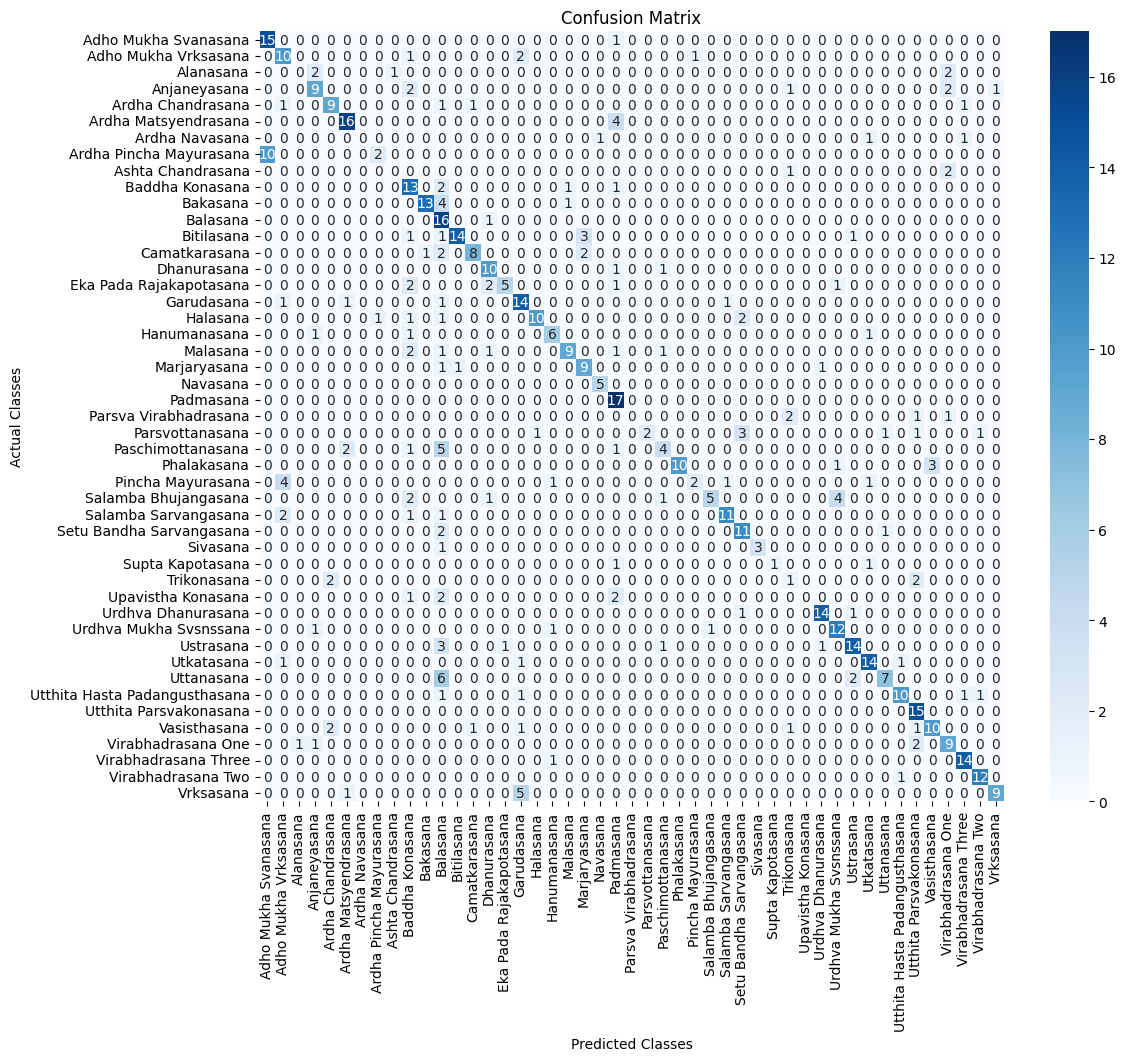

In [85]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, ensemble_wa_label)

# Ensure labels is a list of class names
plt.figure(figsize=(12, 10))  # Increase figure size for clarity
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,  # Use the list directly
            yticklabels=labels)  # Use the list directly
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")

# Save the confusion matrix as an image
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


In [88]:
from sklearn.metrics import classification_report

classification_report_wa = classification_report(y_true, ensemble_wa_label)

print(classification_report_wa)

              precision    recall  f1-score   support

           0       0.65      0.81      0.72        16
           1       0.44      0.29      0.35        14
           2       0.00      0.00      0.00         5
           3       0.55      0.73      0.63        15
           4       0.88      0.54      0.67        13
           5       0.80      0.80      0.80        20
           6       0.00      0.00      0.00         3
           7       0.75      0.50      0.60        12
           8       0.00      0.00      0.00         3
           9       0.44      0.82      0.57        17
          10       0.93      0.78      0.85        18
          11       0.57      0.94      0.71        17
          12       0.71      0.75      0.73        20
          13       0.80      0.62      0.70        13
          14       1.00      0.83      0.91        12
          15       0.83      0.45      0.59        11
          16       0.61      0.78      0.68        18
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
